In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)


# Load and process data

In [3]:
# read data from csv file
trainset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/trainset.csv')
testset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/testset.csv')
print(trainset.shape)
print(testset.shape)

(80000, 15)
(20000, 15)


In [4]:
trainset

,0_Ca,0_Cl,0_Na,0_K,0_N5,1_Ca,1_Cl,1_Na,1_K,1_N5,out_Ca,out_Cl,out_Na,out_K,out_N5
0,0.341575,1.159034,0.012636,0.451710,0.794808,0.347226,0.116634,0.755911,0.674340,1.359338,0.3233,1.1590,0.02901,0.4719,0.79480
1,0.638607,0.558054,1.231009,0.243433,1.132821,0.038278,0.185744,0.734268,1.464984,1.489907,0.4584,0.5581,1.24700,0.5882,1.13300
2,0.787981,0.763241,0.349968,0.738449,1.452716,1.117356,0.110285,0.393380,0.282715,1.466671,0.8053,0.7632,0.34980,0.7038,1.45300
3,0.466115,0.948450,0.942671,1.051085,1.358636,0.470234,0.252135,0.914662,1.318543,1.076570,0.4558,0.9484,0.94180,1.0730,1.35900
4,0.452663,0.644895,1.360873,0.991130,0.162887,1.361588,1.475943,0.637112,0.397679,1.414160,0.4939,0.6449,1.34300,0.9266,0.16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.796601,0.398041,1.132371,0.996845,0.094560,1.074895,1.055513,0.777877,0.870241,0.361988,0.8083,0.3980,1.12600,0.9802,0.09456
79996,0.942419,1.456538,1.164360,0.775981,0.069458,1.024540,1.025283,0.144121,1.438743,0.241862,0.9305,1.4570,1.15000,0.8141,0.06946
79997,1.095302,0.438446,1.335379,0.365207,0.273701,0.765942,0.880543,1.152310,1.119219,1.104459,1.0670,0.4384,1.33500,0.4223,0.27370
79998,0.310626,0.661302,0.192742,1.280823,0.931653,0.199012,0.072267,0.870017,0.563615,0.006399,0.3275,0.6613,0.21380,1.2260,0.93170


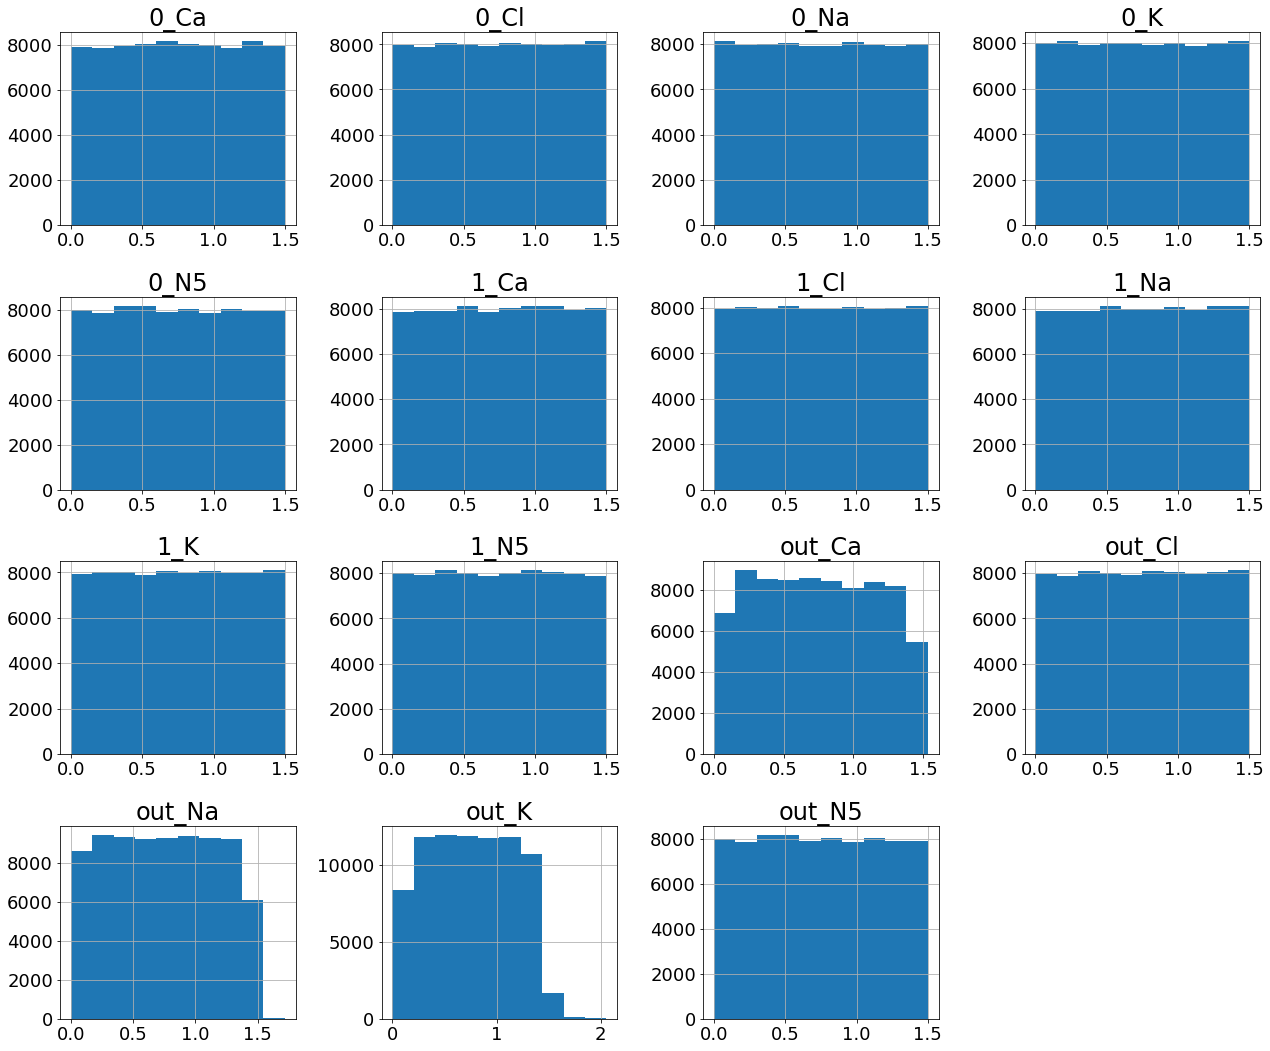

In [5]:
trainset.hist(figsize=(18, 15));
plt.tight_layout()

In [6]:
# split x and y
X_train = trainset.iloc[:, [0,2,3,5,7,8]].values 
y_train = trainset.iloc[:, [10, 12, 13]].values
X_test = testset.iloc[:, [0,2,3,5,7,8]].values 
y_test = testset.iloc[:, [10, 12, 13]].values

# Name variables
inputs = [list(trainset)[i] for i in [0,2,3,5,7,8]] 
outputs = [list(trainset)[i] for i in [10, 12, 13]] # do not work for list -> list(trainset)[10, 12, 13]

In [7]:
print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['0_Ca', '0_Na', '0_K', '1_Ca', '1_Na', '1_K']
Outputs:  ['out_Ca', 'out_Na', 'out_K']
X_train instances:  (80000, 6)
X_test instances:  (20000, 6)
y_train instances:  (80000, 3)
y_test instances:  (20000, 3)


## Normalize data

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

# Fine Tuning

## sklearn XGBRF

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try combinations of hyperparameters
    {'subsample': [0.6, 0.8, 1.0], 
     'n_estimators': [50, 75, 100], 
     'colsample_bynode': [0.4, 0.6, 0.8, 1.0],
     'max_depth': [10, 20, 30],
     'reg_lambda': [1.0, 1e-3, 1e-6]}  
    ]

# train across 3 folds
grid_search = GridSearchCV(xgb.XGBRFRegressor(objective='reg:squarederror', nthread=1, random_state=42),
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, 
                           verbose = 1,
                           n_jobs= 25)

start = time.time()
grid_search.fit(X_train_norm, y_train)
print("Run time = ", time.time()-start)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Run time =  1896.470917224884


In [18]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best score:      {-grid_search.best_score_:0.5f} (+/-{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:0.5f})")
    

best parameters: {'colsample_bynode': 0.6, 'max_depth': 30, 'n_estimators': 100, 'reg_lambda': 1e-06, 'subsample': 1.0}
best score:      0.00007 (+/-0.00000)


In [19]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score
161,"{'colsample_bynode': 0.6, 'max_depth': 30, 'n_...",1,-1.291639e-08,1.405431e-10,-0.000067,0.000003
134,"{'colsample_bynode': 0.6, 'max_depth': 20, 'n_...",2,-6.834572e-08,9.972883e-10,-0.000067,0.000003
152,"{'colsample_bynode': 0.6, 'max_depth': 30, 'n_...",3,-1.282616e-08,1.403507e-10,-0.000069,0.000003
125,"{'colsample_bynode': 0.6, 'max_depth': 20, 'n_...",4,-1.084757e-07,7.072331e-10,-0.000069,0.000003
160,"{'colsample_bynode': 0.6, 'max_depth': 30, 'n_...",5,-3.843864e-06,6.294632e-08,-0.000069,0.000005
...,...,...,...,...,...,...
19,"{'colsample_bynode': 0.4, 'max_depth': 10, 'n_...",320,-4.618262e-03,1.354862e-04,-0.004813,0.000170
1,"{'colsample_bynode': 0.4, 'max_depth': 10, 'n_...",321,-4.689565e-03,3.017559e-04,-0.004866,0.000289
0,"{'colsample_bynode': 0.4, 'max_depth': 10, 'n_...",322,-4.721185e-03,2.017721e-04,-0.004880,0.000175
18,"{'colsample_bynode': 0.4, 'max_depth': 10, 'n_...",323,-4.763800e-03,8.977666e-05,-0.004938,0.000130


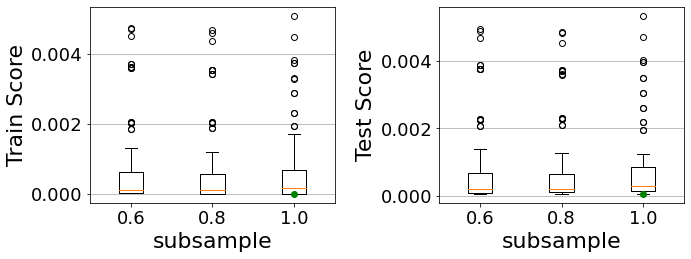

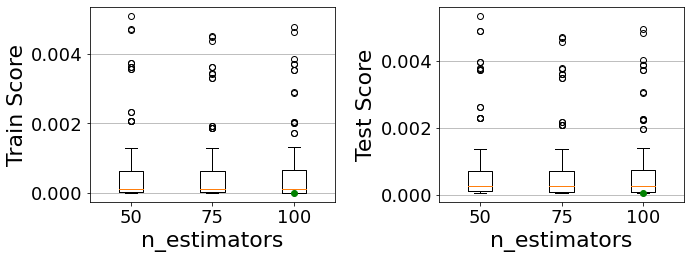

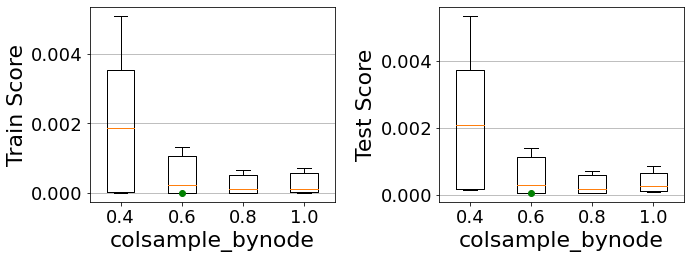

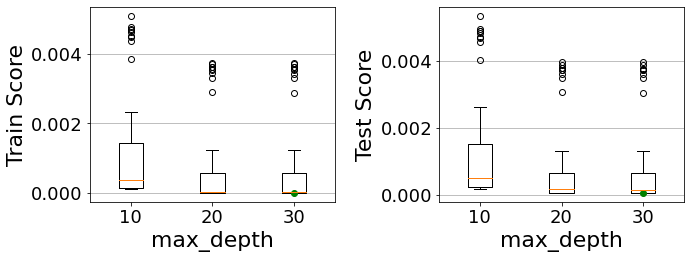

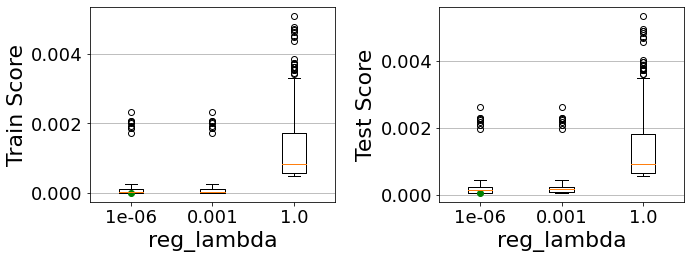

In [20]:
for param_name in param_grid[0]:

    params = sorted(results_df['param_' + param_name].unique())
    means_train = [-results_df[results_df['param_' + param_name] == p]['mean_train_score'] for p in params]
    means_test = [-results_df[results_df['param_' + param_name] == p]['mean_test_score'] for p in params]

    # plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    axes[0].boxplot(means_train)
    axes[0].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 'go')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Train Score')
    
    axes[1].boxplot(means_test)
    axes[1].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_test_score'][grid_search.best_index_], 'go')    
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('Test Score')
    
    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticks([x+1 for x in range(len(params))], labels=list(map(str, params)))
    
    plt.tight_layout()
    plt.show()

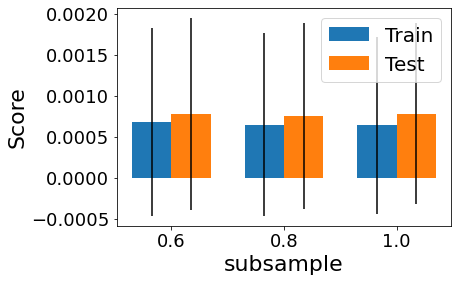

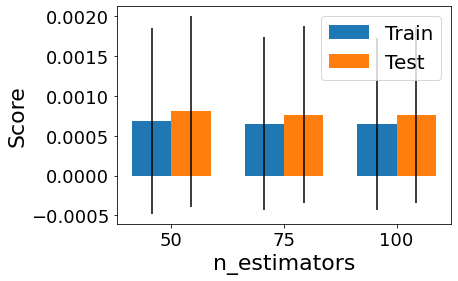

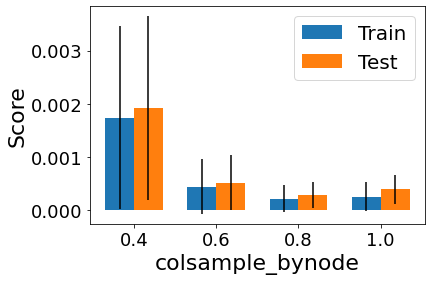

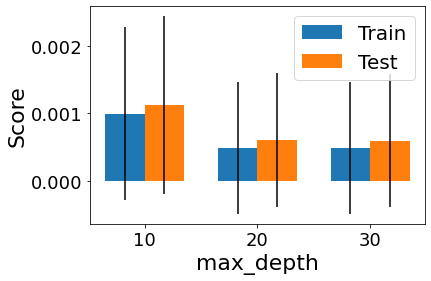

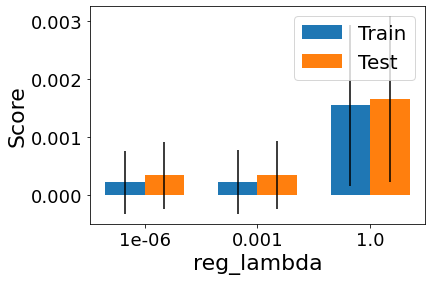

In [21]:
for param_name in param_grid[0]:
    
    results_dfg = results_df.groupby('param_' + param_name)
    params = results_dfg.groups.keys() # or params = results_df['param_' + param_name].unique()
    means_train = -results_dfg.mean()['mean_train_score']
    stds_train = results_dfg.std()['mean_train_score']
    means_test = -results_dfg.mean()['mean_test_score']
    stds_test = results_dfg.std()['mean_test_score']

    # plot
    fig, ax = plt.subplots()
    
    x = np.arange(len(params))  # the label locations
    width = 0.35  # the width of the bars

    ax.bar(x - width/2, means_train, width, yerr=stds_train, label = 'Train')
    ax.bar(x + width/2, means_test, width, yerr=stds_test, label = 'Test')
    ax.set_xticks(x, list(map(str, params)))
    ax.set_xlabel(param_name)
    ax.set_ylabel('Score')
    ax.legend()
    plt.show()

In [22]:
reg_best = grid_search.best_estimator_

print(grid_search.best_params_, end='\n')
print(grid_search.best_estimator_)

{'colsample_bynode': 0.6, 'max_depth': 30, 'n_estimators': 100, 'reg_lambda': 1e-06, 'subsample': 1.0}
XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=0.6, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='', max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=30,
               max_leaves=0, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
               num_parallel_tree=100, objective='reg:squarederror',
               predictor='auto', random_state=42, reg_alpha=0, ...)


In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0698592169593954 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 1.0, 'subsample': 0.6}
0.06975519074161463 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 1.0, 'subsample': 0.8}
0.07299140468656186 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 1.0, 'subsample': 1.0}
0.04774021922728502 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 0.001, 'subsample': 0.6}
0.04801076881311796 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 0.001, 'subsample': 0.8}
0.051082761551062554 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 0.001, 'subsample': 1.0}
0.04773592788249113 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 1e-06, 'subsample': 0.6}
0.04800437742459646 {'colsample_bynode': 0.4, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 1e-06, 'subsample': 0.8}
0.051074167286036434 {'colsamp

In [24]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]), key=lambda cvres: cvres[0], reverse=False)

[(0.008175922875560867,
  {'colsample_bynode': 0.6,
   'max_depth': 30,
   'n_estimators': 100,
   'reg_lambda': 1e-06,
   'subsample': 1.0}),
 (0.008189505868042811,
  {'colsample_bynode': 0.6,
   'max_depth': 20,
   'n_estimators': 100,
   'reg_lambda': 1e-06,
   'subsample': 1.0}),
 (0.008307845351879664,
  {'colsample_bynode': 0.6,
   'max_depth': 30,
   'n_estimators': 75,
   'reg_lambda': 1e-06,
   'subsample': 1.0}),
 (0.008327331109861039,
  {'colsample_bynode': 0.6,
   'max_depth': 20,
   'n_estimators': 75,
   'reg_lambda': 1e-06,
   'subsample': 1.0}),
 (0.008327633579296457,
  {'colsample_bynode': 0.6,
   'max_depth': 30,
   'n_estimators': 100,
   'reg_lambda': 1e-06,
   'subsample': 0.8}),
 (0.008334434389575079,
  {'colsample_bynode': 0.8,
   'max_depth': 30,
   'n_estimators': 100,
   'reg_lambda': 1e-06,
   'subsample': 0.8}),
 (0.00833578201380209,
  {'colsample_bynode': 0.8,
   'max_depth': 20,
   'n_estimators': 100,
   'reg_lambda': 1e-06,
   'subsample': 0.8}),
 (

In [25]:
sorted(zip(reg_best.feature_importances_, inputs), reverse=True)

[(0.39417756, '0_K'),
 (0.33045435, '0_Na'),
 (0.25233713, '0_Ca'),
 (0.011438221, '1_Ca'),
 (0.010423971, '1_K'),
 (0.0011688272, '1_Na')]

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -59.48054528236389

mse:  1.3268140379017044e-08
rmse:  0.00011518741415196819
mae:  8.413631044723742e-05

R2:  0.9999999238816474


In [27]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -12.376846313476562

mse:  5.444089854187307e-05
rmse:  0.007378407588489068
mae:  0.003581878538411237

R2:  0.9996799945734209


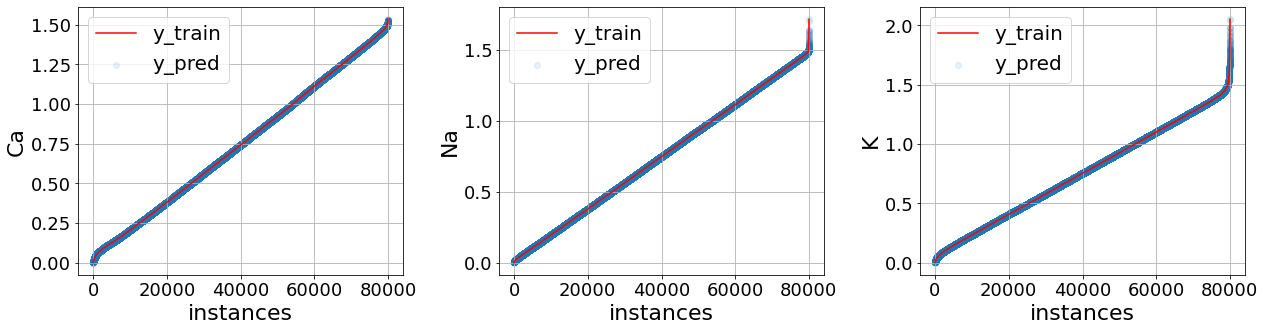

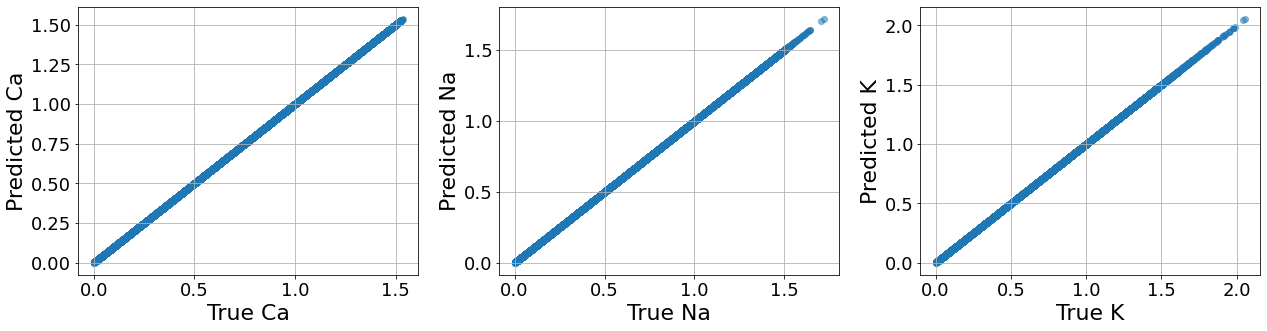

In [28]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_train[:,i]
    aux_pred = y_train_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_train[:,i], y_train_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

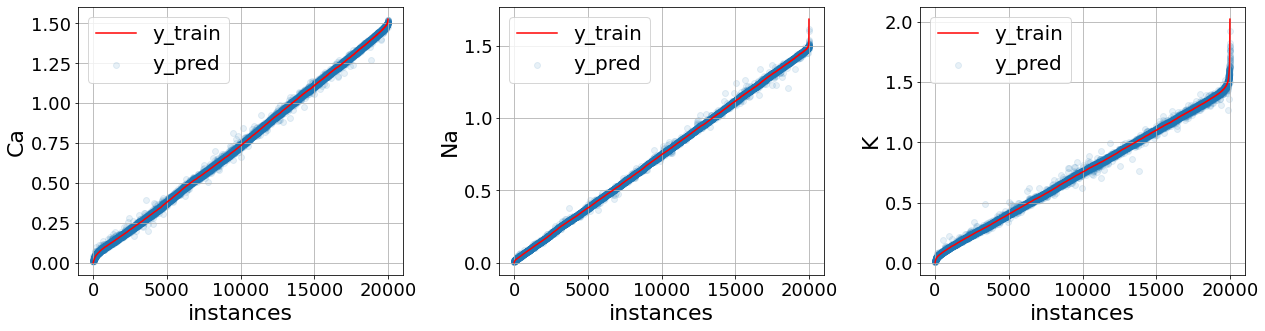

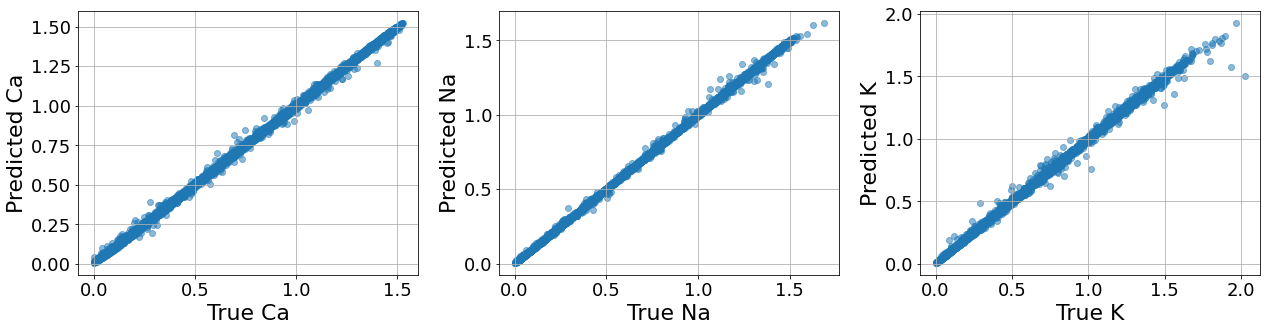

In [29]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_test[:,i]
    aux_pred = y_test_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[:,i], y_test_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

## Run time

In [30]:
start = time.time()
for i in range(1000):  
    reg_best.predict(X_test_norm[0:1])
end = time.time()
print("time = ", (start - end)/1000)
print()

time =  -0.001675180196762085



## Model persistence

In [31]:
final_model = Pipeline([
        ("norm", norm_pipeline),
        ("reg", reg_best)
        ])

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model.predict(X_test))))

rmse:  0.007378407588489068


In [10]:
import joblib
from sklearn.metrics import mean_squared_error

#joblib.dump(final_model, "XGBRFmodel.pkl")
final_model_loaded = joblib.load("XGBRFmodel.pkl") 

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model_loaded.predict(X_test))))

rmse:  0.007397233266000831


In [11]:
# Add Physics-constrained

y_test_pred = final_model_loaded.predict(X_test)
y_test_pred = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse: 0.006413241169834502


In [13]:
start = time.time()
final_model_loaded = joblib.load("XGBRFmodel.pkl") 
end_load = time.time()
print('Load time = ', end_load - start)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1])
end = time.time()    
print('Prediction time 1 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1000])
end = time.time()    
print('Prediction time 1000 = ', (end - start)/1000)
#start = time.time()
#for i in range(1000):    
#    y_pred = final_model_loaded.predict(X_test[0:10000])
#end = time.time()    
#print('Prediction time 10,000 = ', (end - start)/1000)

Load time =  1.9802138805389404
Prediction time 1 =  0.0012160604000091553
Prediction time 1000 =  0.3828878507614136


## Model persistence Multi-Threading

In [15]:
import xgboost as xgb

reg_best2 = xgb.XGBRFRegressor(objective='reg:squarederror', 
                               colsample_bynode= 0.6, 
                               max_depth= 30, 
                               n_estimators= 100, 
                               reg_lambda= 1e-06, 
                               subsample= 1.0,
                               nthread=-1, 
                               random_state=42)
                           
start = time.time()
reg_best2.fit(X_train_norm, y_train)
print("Run time = ", time.time()-start)

Run time =  1256.462760925293


In [16]:
final_model = Pipeline([
        ("norm", norm_pipeline),
        ("reg", reg_best2)
        ])

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model.predict(X_test))))

rmse:  0.007378407588489068


In [17]:
import joblib
from sklearn.metrics import mean_squared_error

joblib.dump(final_model, "XGBRFmodel_multithread.pkl")
final_model_loaded = joblib.load("XGBRFmodel_multithread.pkl") 

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model_loaded.predict(X_test))))

rmse:  0.007378407588489068


In [18]:
start = time.time()
final_model_loaded = joblib.load("XGBRFmodel_multithread.pkl") 
end_load = time.time()
print('Load time = ', end_load - start)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1])
end = time.time()    
print('Prediction time 1 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1000])
end = time.time()    
print('Prediction time 1000 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:10000])
end = time.time()    
print('Prediction time 10,000 = ', (end - start)/1000)

Load time =  2.2195332050323486
Prediction time 1 =  0.0021656634807586668
Prediction time 1000 =  0.0527649986743927
Prediction time 10,000 =  0.09611693263053894
